# Parametric estimation of Value-at-Risk and Expected Shortfall
We will use the same dataset returns on SP500 as in the non-parametric notebook

In [1]:
#Import packages
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import datetime as dt
import numpy as np
from scipy import stats
import math as m
from matplotlib import pyplot as plt
from arch import arch_model 



Arch is not included in Anaconda, for windows type 'conda install -c conda-forge arch-py' without the ' ' in the anaconda prompt (run as admin)

In [2]:
# Read CSV file, set dates as index, pick last 5 years of data
filename='sp500.csv'
table = pd.read_csv(filename)
table['caldt'] = pd.to_datetime(table['caldt'])
table = table.set_index('caldt')
start = dt.datetime(2016, 1, 1)
end = dt.datetime(2020,12,31)
our_sample = table[start:end]
our_sample['losses'] = our_sample['vwretd']*-1
print(our_sample)

              vwretd    losses
caldt                         
2016-01-04 -0.015190  0.015190
2016-01-05  0.002134 -0.002134
2016-01-06 -0.012566  0.012566
2016-01-07 -0.023433  0.023433
2016-01-08 -0.010898  0.010898
...              ...       ...
2020-12-24  0.003623 -0.003623
2020-12-28  0.008938 -0.008938
2020-12-29 -0.002240  0.002240
2020-12-30  0.001475 -0.001475
2020-12-31  0.006367 -0.006367

[1259 rows x 2 columns]


To get the parameters for a distribution we typically use maximum likelihood estimation, that is we pick the parameter values that maximes the probability that the assumed distribution has generated the observed sample. So you would take the pdf (see slide 5 on Video lecture 7) put in the first loss observation instead of l in the formula and then multiply with the pdf for the second and so on and maximize this expression for $\mu$ and $\sigma$. For the normal distribution this will give a solution that is equal to the sample mean and sample variance

In [3]:
sample_mu = np.mean(our_sample.losses)
sample_sigma = np.std(our_sample.losses)
print("Sample mu is {:.5f} and sample sigma is {:.5f}".format(sample_mu,sample_sigma))

Sample mu is -0.00064 and sample sigma is 0.01207


In [4]:
# Instead of writing down the (log) likelihood function we use the built in function 
mu, std = stats.norm.fit(our_sample.losses)
print("ML estimate of mu is {:.5f} and ML estimate of sigma is {:.5f}".format(mu,std))

ML estimate of mu is -0.00064 and ML estimate of sigma is 0.01207


When we have the parameters we already know (see code from lecture 2) how to estimate VaR and ES when changes in the loss distribution is N. 

In [5]:
alpha = 0.99
VaR99_n = stats.norm.ppf(alpha,loc=mu,scale=std) 
print("VaR assuming normality {:.4f}".format(VaR99_n))

VaR assuming normality 0.0274


In [6]:
exact_ES99 = mu+(std*1/m.sqrt(2*m.pi)*m.exp(-0.5*stats.norm.ppf(alpha)**2))/(1-alpha)
print("ES assuming mornality {:.4f}".format(exact_ES99))

ES assuming mornality 0.0315


In [7]:
# But is normality a good assumption?
print(stats.jarque_bera(our_sample.losses))

Jarque_beraResult(statistic=21639.885777101357, pvalue=0.0)


In [8]:
print("Sample skewness {:.2f}".format(stats.skew(our_sample.losses)))

Sample skewness 0.72


In [9]:
print("Sample kurtosis {:.2f}".format(stats.kurtosis(our_sample.losses))) # this is excess kurtosis (fourth cental moment -3)

Sample kurtosis 20.26


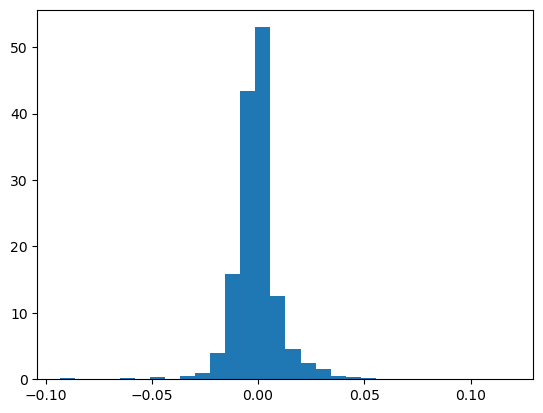

In [10]:
plt.hist(our_sample.losses, 30, density=True);


No, normality is not a good assumption. Our losses have heavy tails and are right skewed (at least for SP500), both of these facts will underestimate VaR and ES if we assume normality
## T-distribution
Note that you have to check which parameterization of the t-distribution your software uses. Compare the documentation https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html with slide 8 of Video lecture 7. Scipy uses $\sigma^*$ This means we have to transform $\sigma^*$ to $\sigma$ to be able to directly use the formulas from the slides for VaR and ES with the t-distribution.

In [11]:
nu,loc,scale = stats.t.fit(our_sample.losses)
print('nu={:.2f} loc={:.4f} and scale={:.4f}'.format(nu,loc,scale))

nu=1.94 loc=-0.0011 and scale=0.0051


This distribution is so fat tailed that variance is not defined (since $\nu<2$) which means that strictly speaking we cannot compute VaR or ES. To illustrate the calculations we "pretend" that nu is $\nu=2.5$ and use my and sigma from our estimate of the normal distribution (if we only change $\nu$ we will underestimate sigma)


In [12]:
nu = 2.5
sig = m.sqrt(nu/(nu-2))*std
VaR99_t = mu+m.sqrt((nu-2)/nu)*sig*stats.t.ppf(alpha,nu) # Slide 11 Video lecture 7
print("VaR assuming t-distribution {:.4f}".format(VaR99_t))

VaR assuming t-distribution 0.0640


In [13]:
part1 = m.sqrt((nu-2)/nu)*sig*stats.t.pdf(stats.t.ppf(alpha,nu),nu)
part2 = 1/(1-alpha)*(nu+stats.t.ppf(alpha,nu)**2)/(nu-1)
ES99_t = mu+part1*part2 # Slide 13 Video lecture 7
print("ES assuming t-distribution {:.4f}".format(ES99_t))

ES assuming t-distribution 0.1091


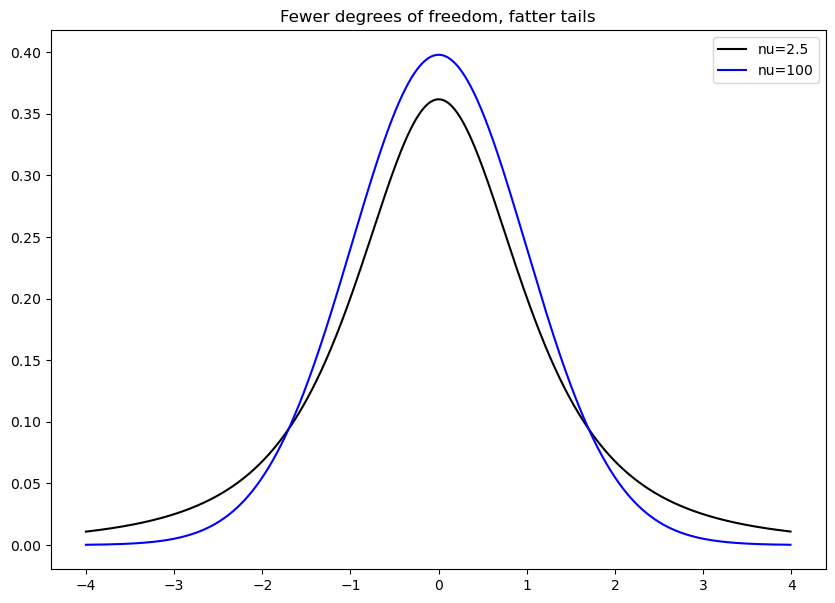

In [14]:
x_values = np.arange(-4,4,0.01)
pdf_fat = stats.t.pdf(x_values, 2.5) #Compute probability density function
pdf_thin = stats.t.pdf(x_values, 100) #Compute probability density function
fig,ax=plt.subplots()
ax.plot(x_values, pdf_fat, label="nu=2.5",color='black') #Plot PDF
ax.plot(x_values, pdf_thin, label="nu=100",color='blue') #Plot PDF
ax.legend()#Legend entries
ax.set_title('Fewer degrees of freedom, fatter tails');
fig.set_size_inches(10, 7)

Note that fatter tails (higher kurtosis) generally means that the ratio ES/VaR is higher.
## GARCH
We can get our parameter estimates from a (Gaussian) GARCH model to incorporate time-varying volatility, typically we want the VaR/ES for tomorrow so we would make a forecast from the model. We estimate the standard GARCH(1,1) assuming mean returns are zero.

In [15]:
# a standard GARCH(1,1) model
garch = arch_model(100*our_sample.losses, vol='garch', p=1, o=0, q=1)
garch_fitted = garch.fit()
print(garch_fitted)


Iteration:      1,   Func. Count:      6,   Neg. LLF: 663631.6468922277
Iteration:      2,   Func. Count:     15,   Neg. LLF: 3012749554.401969
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1926.8653686617706
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1503.990538725709
Iteration:      5,   Func. Count:     34,   Neg. LLF: 4907.621241810186
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1502.9384588619127
Iteration:      7,   Func. Count:     46,   Neg. LLF: 1502.7880833791637
Iteration:      8,   Func. Count:     51,   Neg. LLF: 1502.7879941467265
Iteration:      9,   Func. Count:     56,   Neg. LLF: 1502.7879920641813
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1502.7879920641615
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1502.7879920641813
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results        

In [16]:
(mu, omega,alpha,beta)= garch_fitted.params
omega = omega/10000 # Since rescaled returns before estimation
T = len(our_sample)
v = np.empty(T)
var99_garch = np.empty(T)
v[0] = omega / (1-alpha-beta) # Set first variance to unconditional variance
var99_garch[0] = mu/100+np.sqrt(v[0])*stats.norm.ppf(0.99)

for j in range(1,len(our_sample.losses)): # Forecast for all five years
    v[j] = omega+alpha*(our_sample.losses[j-1]**2)+beta*v[j-1]
    var99_garch[j] = mu/100+np.sqrt(v[j])*stats.norm.ppf(0.99)
    

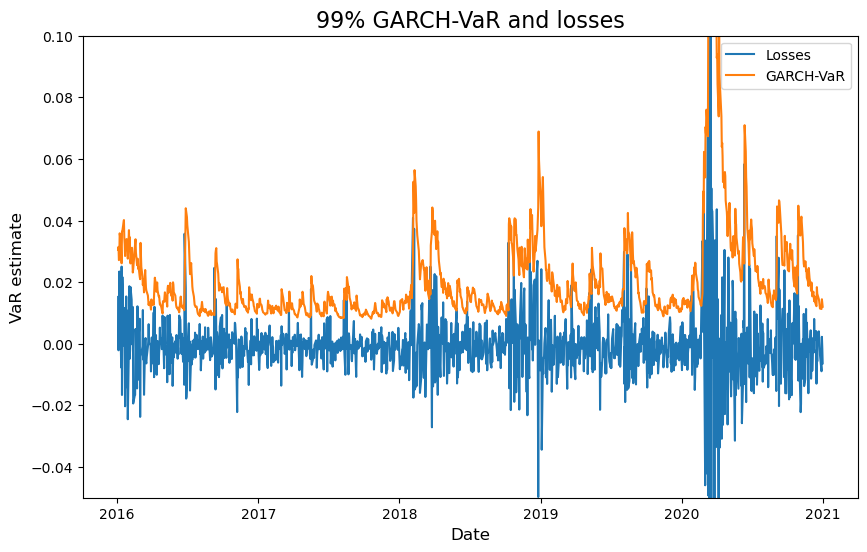

In [17]:

our_sample.insert(2,'GARCH-VaR',var99_garch)
fig,ax=plt.subplots()
ax.plot(our_sample['losses'],label='Losses')
ax.plot(our_sample['GARCH-VaR'],label='GARCH-VaR')
ax.set_ylim(-0.05, 0.1)
plt.xlabel('Date',fontsize=12)
plt.ylabel('VaR estimate',fontsize=12)
plt.title('99% GARCH-VaR and losses',fontsize=16)
plt.legend()
fig.set_size_inches(10, 6)

## Generalized Pareto distribution (POT method)
We follow the three steps from slide 15 in Video lecture 7
Create the subsample of big losses (we take the 5% of the largest losses but this choice is arbitrary and not the same as the VaR level you want to estimate)


In [23]:
alpha = 0.99;

u = np.quantile(our_sample.losses,0.95)
large_losses = our_sample.losses[our_sample.losses>u]-u
print(large_losses)

caldt
2016-01-07    0.006013
2016-01-13    0.007630
2016-01-15    0.004246
2016-02-02    0.001248
2016-02-05    0.001003
                ...   
2020-09-08    0.010501
2020-09-10    0.000157
2020-09-23    0.006407
2020-10-26    0.000974
2020-10-28    0.017778
Name: losses, Length: 63, dtype: float64


In [24]:
(xsi,loc,beta) = stats.genpareto.fit(large_losses,floc=0) # Setting localtion to zero
print((xsi,loc,beta))

(0.2486367759991097, 0, 0.010026336694155785)


In [25]:
N = len(our_sample)
N_u = len(large_losses)
middlePart = (N/N_u)*(1-alpha) # The "middle part" of the VaR equation on slide 18 just to improve readability
VaR99_pot = u+(beta/xsi)*((middlePart**(-xsi))-1)
ES99_pot = (VaR99_pot+beta-xsi*u)/(1-xsi)
print("VaR using POT is {:.4f}".format(VaR99_pot))
print("ES using POT is {:.4f}".format(ES99_pot))

VaR using POT is 0.0373
ES using POT is 0.0572


## Suggested exercises for practice (not graded and not for hand-in)
Write functions for computing VaR and ES using the POT method. Then use your function to see how sensitive the risk measures are to the choice of cut-off point, we only used the 5% largest losses in our example.

Redo the analysis on a different dataset, use eg pandas_datareader to directly access data from yahoo finance. It needs to be installed using: conda install -c anaconda pandas-datareader
It now also needs the package yfinance conda install -c conda-forge yfinance
hen you can use it like this:


[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'tsla')

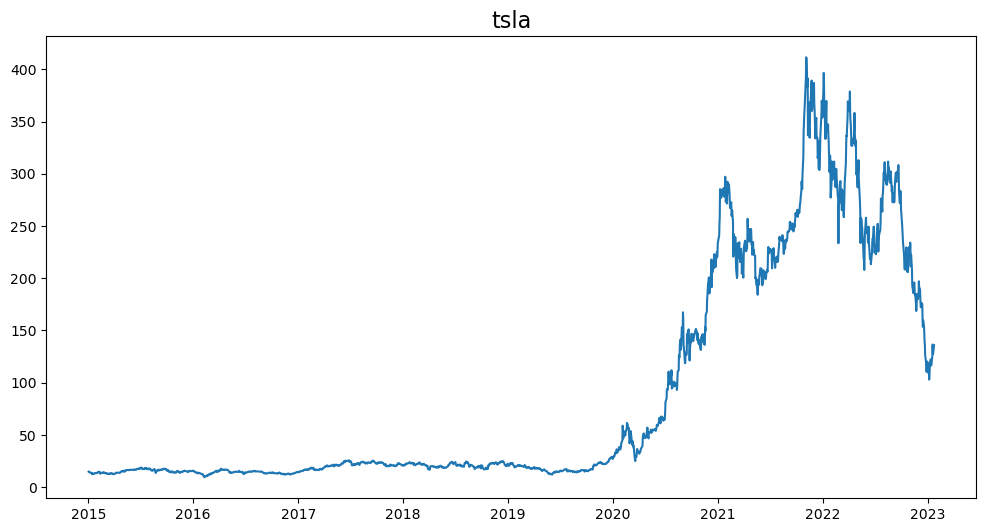

In [22]:
import pandas_datareader.data as pdr
import yfinance as yf
yf.pdr_override()
start = dt.datetime(2015, 1, 1)
end = dt.datetime(2023, 1, 24)
ticker='tsla'
tsla = pdr.get_data_yahoo(ticker,start=start, end=end)
fig,ax=plt.subplots()
ax.plot(tsla.Open)
fig.set_size_inches(12, 6)
plt.title(ticker,fontsize=16)